In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train1.csv')
df_train

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv('test1.csv')
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [6]:
df_train.shape

(159571, 8)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [16]:
df_train.corr()

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
rude,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
loathe,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


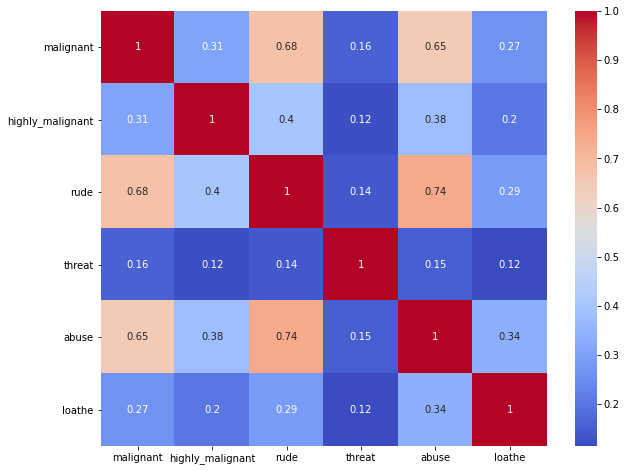

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df_train.corr(), annot = True, cmap= "coolwarm")
plt.show()

In [4]:
# Remoivng Column ID
df_train.drop('id',axis=1,inplace=True)

In [5]:
def clean_text_and_replace(df_column):
    
    # Making all lower case
    df_column = df_column.str.lower()
    
    # Replace email address with 'email'
    df_column = df_column.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','EMAIL_ADDRESS',regex=True)

    #ReplaceURLs with 'webaddress'
    df_column = df_column.str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','WEB_ADDRESS',regex=True)

    #Replace money symbols with 'moneysymb'
    df_column = df_column.str.replace(r'£|\$','DOLLER',regex=True)

    #Replace 10 digit phone number 
    df_column = df_column.str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','PHONE_NUMBER',regex=True)

    #Replace numbers with 'numbr'
    df_column = df_column.str.replace(r'\d+(\.\d+)?', 'NUMBER',regex=True)

    # Remove Punctuation 
    df_column = df_column.str.replace(r'[^\w\d\s]',' ',regex=True)

    #Replace Whitspace between terms with  a single space
    df_column = df_column.str.replace(r'\s+',' ',regex=True)

    #Remove leading and trailing whitespace
    df_column = df_column.str.replace(r'^\s+|\s+?$',' ',regex=True)

    # Remove Stop words 
    stop_words = set(stopwords.words('english') + ['u','ur','4','2','im','dont','doin','I','numbr','YOU','You','A','If','one','The','page','would','article','talk','like','know','THE','people','get'])
    df_column = df_column.apply(lambda x: ' '.join(
            term for term in x.split() if term not in stop_words 
        ))
    
    
    return df_column

In [6]:
df_train['comment_text'] = clean_text_and_replace(df_train['comment_text'])

In [7]:
df_train['comment_text'].str.lower()

0         explanation edits made username hardcore metal...
1         aww matches background colour seemingly stuck ...
2         hey man really trying edit war guy constantly ...
3         make real suggestions improvement wondered sec...
4                                  sir hero chance remember
                                ...                        
159566    second time asking view completely contradicts...
159567             ashamed horrible thing put number number
159568    spitzer umm theres actual prostitution ring cr...
159569    looks actually put speedy first version delete...
159570    really think understand came idea bad right aw...
Name: comment_text, Length: 159571, dtype: object

In [8]:
df_test['comment_text'] = clean_text_and_replace(df_test['comment_text'])

In [9]:
df_test['comment_text']

0         yo bitch ja rule succesful ever whats hating s...
1                                        rfc title fine imo
2                               sources zawe ashton lapland
3         look back source information updated correct f...
4                                 anonymously edit articles
                                ...                        
153159                totally agree stuff nothing long crap
153160    throw field home plate faster throwing cut man...
153161    okinotorishima categories see changes agree co...
153162    founding nations eu germany law return quite s...
153163    stop already bullshit welcome fool think kind ...
Name: comment_text, Length: 153164, dtype: object

In [13]:
df_train.columns

Index(['comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

In [10]:
list_of_type = [ 'malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']

In [11]:
df_train[list_of_type]

,malignant,highly_malignant,rude,threat,abuse,loathe
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


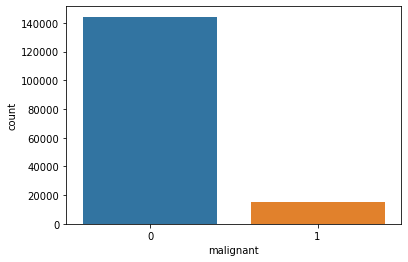

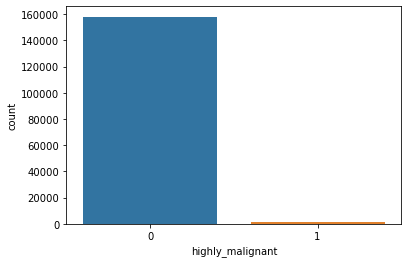

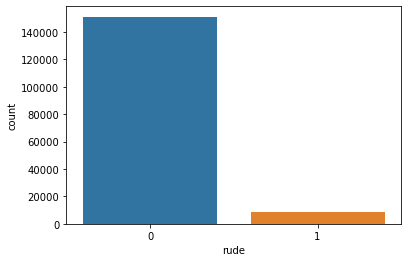

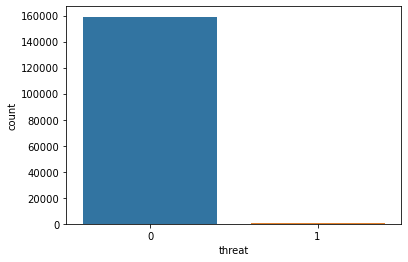

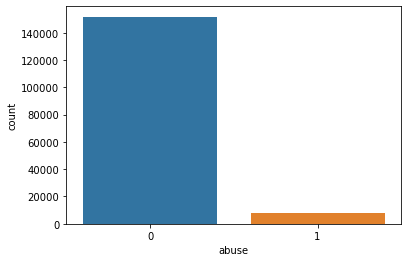

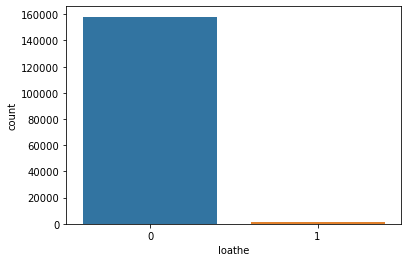

In [20]:
columns=['malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe']
for i in columns:
    sns.countplot(df_train[i])
    plt.show()

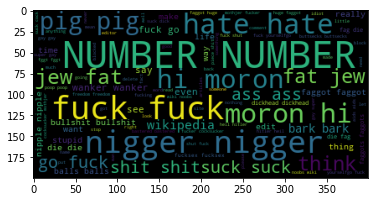

In [21]:
# For malignant
wordCloud = WordCloud(max_words=100).generate(' '.join(df_train['comment_text'][df_train['malignant'] == 1]))
plt.imshow(wordCloud)

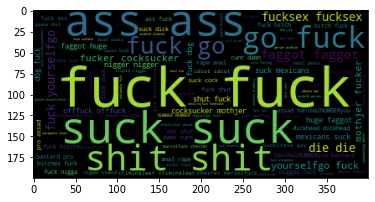

In [22]:
# For highly_malignant
wordCloud = WordCloud(max_words=100).generate(' '.join(df_train['comment_text'][df_train['highly_malignant'] == 1]))
plt.imshow(wordCloud)

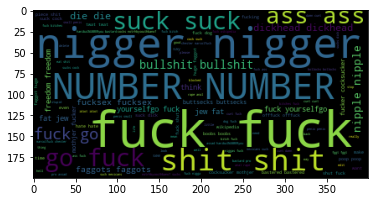

In [23]:
# For rude
wordCloud = WordCloud(max_words=100).generate(' '.join(df_train['comment_text'][df_train['rude'] == 1]))
plt.imshow(wordCloud)

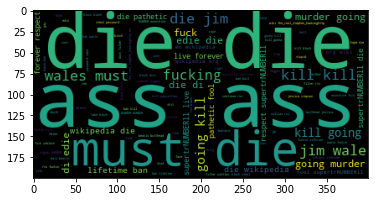

In [24]:
# For threat
wordCloud = WordCloud(max_words=100).generate(' '.join(df_train['comment_text'][df_train['threat'] == 1]))
plt.imshow(wordCloud)

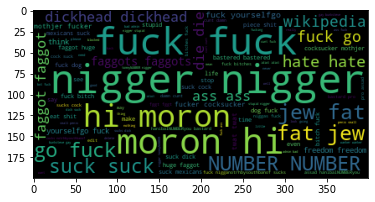

In [25]:
# For abuse
wordCloud = WordCloud(max_words=100).generate(' '.join(df_train['comment_text'][df_train['abuse'] == 1]))
plt.imshow(wordCloud)

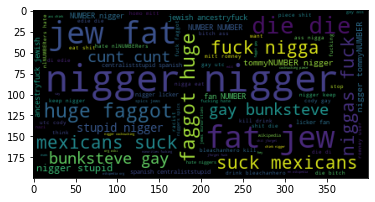

In [26]:
# For loathe
wordCloud = WordCloud(max_words=100).generate(' '.join(df_train['comment_text'][df_train['loathe'] == 1]))
plt.imshow(wordCloud)

In [27]:
count_types = df_train[list_of_type].sum().to_frame().rename(columns={0:'Count'}).sort_values(by='Count')

In [28]:
count_types

,Count
threat,478
loathe,1405
highly_malignant,1595
abuse,7877
rude,8449
malignant,15294


<AxesSubplot:ylabel='Count'>

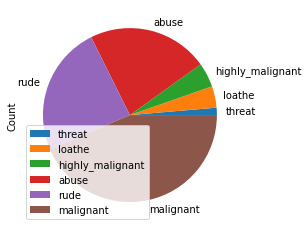

In [29]:
count_types.plot.pie(y='Count')

In [15]:
df_train['label'] = df_train[list_of_type].sum(axis =1)
print(df_train['label'].value_counts())
df_train['label'] = df_train['label'] > 0 
df_train['label'] = df_train['label'].astype(int)
print(df_train['label'].value_counts())

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: label, dtype: int64
0    143346
1     16225
Name: label, dtype: int64


In [16]:
Counter(' '.join(df_train[df_train['label'] == 0]['comment_text']).split()).most_common(10)

[('NUMBER', 147123),
 ('wikipedia', 44490),
 ('please', 28749),
 ('see', 20561),
 ('also', 19808),
 ('think', 18687),
 ('edit', 17229),
 ('articles', 16155),
 ('use', 16081),
 ('may', 15259)]

In [17]:
Counter(' '.join(df_train[df_train['label'] == 1]['comment_text']).split()).most_common(10)

[('fuck', 9999),
 ('NUMBER', 9383),
 ('wikipedia', 3931),
 ('shit', 3693),
 ('fucking', 3337),
 ('nigger', 3306),
 ('suck', 3249),
 ('ass', 3003),
 ('go', 2964),
 ('hate', 2656)]

In [18]:
def tf_idf(text):
    return TfidfVectorizer(min_df=3,smooth_idf=True).fit_transform(text)

In [19]:
X = tf_idf(df_train['comment_text'])
y = df_train['label']

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import joblib
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

In [21]:
models = [LogisticRegression(),KNeighborsClassifier(),BernoulliNB(),DecisionTreeClassifier(),
         RandomForestClassifier(),KNeighborsClassifier(n_neighbors=3)]

In [23]:
for model in models:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('Model for:',model)
    print(accuracy_score(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print('-'*100)

Model for: LogisticRegression()
0.954043943105642
[[47078   185]
 [ 2235  3161]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     47263
           1       0.94      0.59      0.72      5396

    accuracy                           0.95     52659
   macro avg       0.95      0.79      0.85     52659
weighted avg       0.95      0.95      0.95     52659

----------------------------------------------------------------------------------------------------
Model for: KNeighborsClassifier()
0.9021249928787102
[[46443   820]
 [ 4334  1062]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     47263
           1       0.56      0.20      0.29      5396

    accuracy                           0.90     52659
   macro avg       0.74      0.59      0.62     52659
weighted avg       0.88      0.90      0.88     52659

--------------------------------------------------------------------------------

In [24]:
randomForestClassifier = RandomForestClassifier()
randomForestClassifier.fit(X_train,y_train)
y_predict = randomForestClassifier.predict(X_test)
print('accuracy score:',accuracy_score(y_test,y_pred))
print('log loss:',log_loss(y_test,y_pred))
print('Confussion matrix:',confusion_matrix(y_test,y_pred))

accuracy score: 0.915456047399305
log loss: 2.9200471342966265
Confussion matrix: [[47101   162]
 [ 4290  1106]]


In [205]:
tfidVectorizer = TfidfVectorizer(max_features = 51153,stop_words = 'english')
X_test = tfidVectorizer.fit_transform(df_test['comment_text'])

In [206]:
y_predict = randomForestClassifier.predict(X_test)
y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [207]:
pd.DataFrame(y_predict).to_csv('Predicted.csv')

In [210]:
joblib.dump(randomForestClassifier,'randomForestClassifier.model')

['randomForestClassifier.model']

In [216]:
# Parameter Tunning
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)


In [211]:
parameters = {
    'max_depth':range(10,14),
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf':range(1,4)
}
gridSearchCV = GridSearchCV(RandomForestClassifier(),parameters,refit = True, verbose = 3)
gridSearchCV.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END max_depth=10, max_features=auto, min_samples_leaf=1; total time=  12.1s
[CV 2/5] END max_depth=10, max_features=auto, min_samples_leaf=1; total time=  12.0s
[CV 3/5] END max_depth=10, max_features=auto, min_samples_leaf=1; total time=  12.0s
[CV 4/5] END max_depth=10, max_features=auto, min_samples_leaf=1; total time=  13.4s
[CV 5/5] END max_depth=10, max_features=auto, min_samples_leaf=1; total time=  13.6s
[CV 1/5] END max_depth=10, max_features=auto, min_samples_leaf=2; total time=  13.2s
[CV 2/5] END max_depth=10, max_features=auto, min_samples_leaf=2; total time=  12.1s
[CV 3/5] END max_depth=10, max_features=auto, min_samples_leaf=2; total time=  11.9s
[CV 4/5] END max_depth=10, max_features=auto, min_samples_leaf=2; total time=  11.7s
[CV 5/5] END max_depth=10, max_features=auto, min_samples_leaf=2; total time=  12.2s
[CV 1/5] END max_depth=10, max_features=auto, min_samples_leaf=3; total time=  12.0s
[CV

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(10, 14),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': range(1, 4)},
             verbose=3)

In [212]:
gridSearchCV.best_params_

{'max_depth': 13, 'max_features': 'auto', 'min_samples_leaf': 2}

In [218]:
gridSearchCV_pred = gridSearchCV.best_estimator_.predict(X_test)

In [219]:
print(classification_report(y_test,gridSearchCV_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     47263
           1       1.00      0.00      0.00      5396

    accuracy                           0.90     52659
   macro avg       0.95      0.50      0.47     52659
weighted avg       0.91      0.90      0.85     52659



In [220]:
print(accuracy_score(y_test,gridSearchCV_pred))

0.8975673674015838
